# Convolutional Neural Network LeNet

In [1]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


os.environ["CUDA_VISIBLE_DEVICES"]="2"

base_dir = 'uta_dataset/vgg16images'
drowsy_dir = os.path.join(base_dir, 'DrowsyVGG')
alert_dir = os.path.join(base_dir, 'AlertVGG')

# Creating a function to split data.
def create_splits(data_dir, output_dir, split_ratio=(0.7, 0.10, 0.20)):
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    for category in ['DrowsyVGG', 'AlertVGG']:
        category_dir = os.path.join(data_dir, category)
        images = os.listdir(category_dir)
        train_imgs, test_imgs = train_test_split(images, test_size=split_ratio[1] + split_ratio[2], random_state=42)
        val_imgs, test_imgs = train_test_split(test_imgs, test_size=split_ratio[2]/(split_ratio[1] + split_ratio[2]), random_state=42)
        
        for dset, imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            output_dset_dir = os.path.join(output_dir, dset, category)
            os.makedirs(output_dset_dir, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(category_dir, img), output_dset_dir)

# Assuming the dataset is not split yet.
create_splits(base_dir, 'splitted_dataset')

# Preparing the data.
train_dir = os.path.join('splitted_dataset', 'train')
val_dir = os.path.join('splitted_dataset', 'val')
test_dir = os.path.join('splitted_dataset', 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Width = 32
Height = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(Width,Height),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(Width,Height),
    batch_size=20,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(Width,Height),
    batch_size=20,
    class_mode='binary',
    shuffle=False)


2024-02-29 00:15:56.785797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Found 7092 images belonging to 2 classes.
Found 1013 images belonging to 2 classes.
Found 2029 images belonging to 2 classes.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

def make_lenet_5():
    model = models.Sequential([
        layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32, 32, 1), padding="same"),
        layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
        layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
        layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
        layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
        layers.Flatten(),
        layers.Dense(84, activation='tanh'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

lenet_5 = make_lenet_5()
lenet_5.summary()


2024-02-29 00:15:59.312755: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-29 00:15:59.313808: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-29 00:15:59.470147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2024-02-29 00:15:59.470186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-29 00:15:59.473399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-29 00:15:59.473466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 84)                4

In [3]:
model=make_lenet_5()

model.compile(optimizer=optimizers.Adamax(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks.
callbacks = [
    ModelCheckpoint('LeNet_drowsiness_detection.h5', save_best_only=True, monitor='val_accuracy',mode="max")
]

# Train the model.
history = model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,  
    callbacks=callbacks
)


2024-02-29 00:16:06.481881: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-02-29 00:16:06.482270: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/50


2024-02-29 00:16:06.942048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-29 00:16:07.880873: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-02-29 00:16:07.883212: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


 12/100 [==>...........................] - ETA: 1s - loss: 0.6960 - accuracy: 0.4934

2024-02-29 00:16:10.654318: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 7s 30ms/step - loss: 0.6926 - accuracy: 0.5079 - val_loss: 0.6864 - val_accuracy: 0.5700
Epoch 2/50
100/100 [==============================] - 2s 24ms/step - loss: 0.6846 - accuracy: 0.5483 - val_loss: 0.6812 - val_accuracy: 0.5590
Epoch 3/50
100/100 [==============================] - 2s 24ms/step - loss: 0.6801 - accuracy: 0.5653 - val_loss: 0.6764 - val_accuracy: 0.6330
Epoch 4/50
100/100 [==============================] - 2s 24ms/step - loss: 0.6750 - accuracy: 0.5772 - val_loss: 0.6693 - val_accuracy: 0.6120
Epoch 5/50
100/100 [==============================] - 3s 25ms/step - loss: 0.6686 - accuracy: 0.6208 - val_loss: 0.6637 - val_accuracy: 0.5940
Epoch 6/50
100/100 [==============================] - 2s 24ms/step - loss: 0.6671 - accuracy: 0.5687 - val_loss: 0.6569 - val_accuracy: 0.6290
Epoch 7/50
100/100 [==============================] - 3s 25ms/step - loss: 0.6608 - accuracy: 0.6330 - val_loss: 0.6523 - val_accuracy: 0.6600
Epoch 8/50

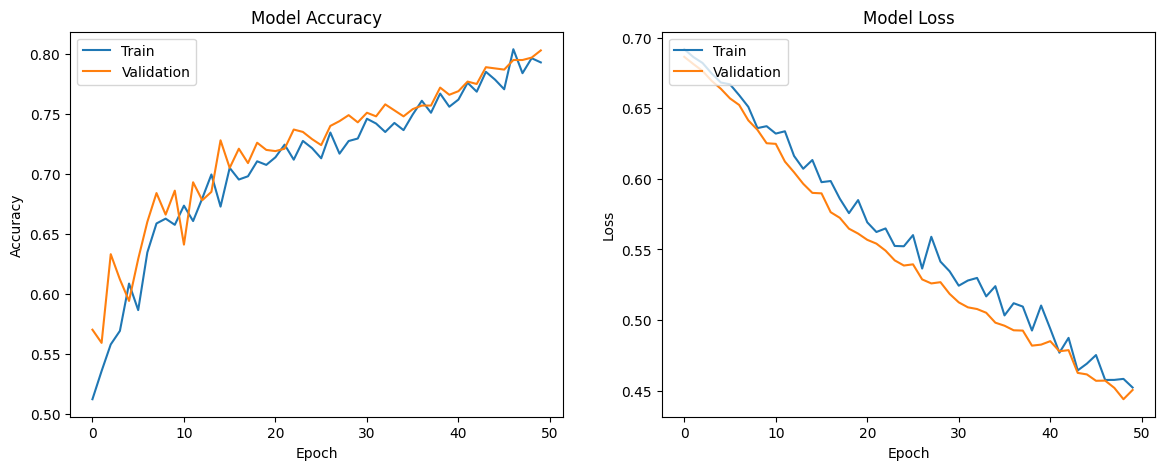

In [4]:
# Plot training & validation accuracy values.
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


50/50 [==============================] - 1s 15ms/step - loss: 0.5709 - accuracy: 0.6950
Test accuracy: 0.6949999928474426
F1 Score: 0.793607305936073


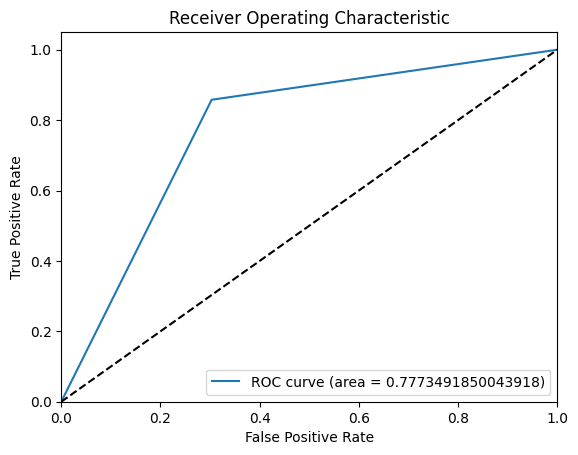

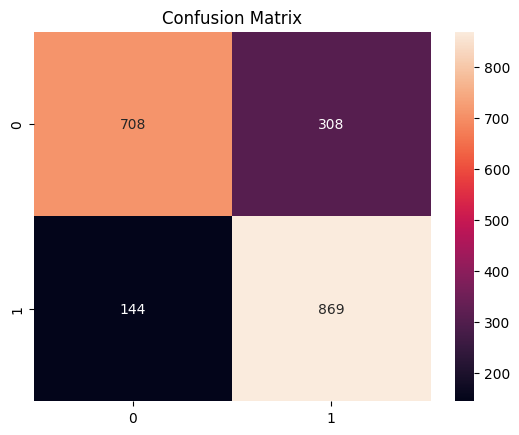

Sensitivity: 0.6968503937007874
Specificity: 0.857847976307996


In [5]:
# Evaluate the model on the test set.
test_loss, test_acc = model.evaluate(test_generator, steps=50)  
print(f"Test accuracy: {test_acc}")

# Predictions for ROC and F1.
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1}")

# ROC Curve.
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix for Sensitivity and Specificity.
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()

# Sensitivity and Specificity.
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


In [6]:
# Carbon Tracker.
import gc
from carbontracker.tracker import CarbonTracker

tracker = CarbonTracker(epochs=50)
tracker.epoch_start()

history_tracker= model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=1,
    validation_data=validation_generator,
    validation_steps=50,  
)
tracker.epoch_end()
tracker.stop()
gc.collect()

CarbonTracker: The following components were found: GPU with device(s) NVIDIA RTX A6000. CPU with device(s) cpu:1, cpu:0.
100/100 [==============================] - 2s 24ms/step - loss: 0.4650 - accuracy: 0.7845 - val_loss: 0.4337 - val_accuracy: 0.8130
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:00:02
	Energy:	0.000208 kWh
	CO2eq:	0.016816 g
	This is equivalent to:
	0.000140 km travelled by car
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:02:00
	Energy:	0.010381 kWh
	CO2eq:	nan g
CarbonTracker: Finished monitoring.


/home/dll/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dll/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


14822